In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../')
from models.lvae import LadderVAE
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from boilerplate import boilerplate
import lib.utils as utils
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [3]:
#### ALL PARANETERS DEFINED HERE ####

supervised = False
augment = False

# Data paths
data_path_signal = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V\Vim_fixed_Avg1-3_no_clipping")
data_path_obs = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\dump\rec\timelapses_gathered")
noiseModelsDir = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models\final")

# Choose parameters
noise_level = 0 # "all",list of int, or int
clean = "avg" # "n2v" or "avg"
display = True # display images or not
clip = -3 # False or clip value

# Get noise model name (enter n_gauss and n_coeff manually)
GMMname = f"GMM_Noise{noise_level}_Sig{clean.upper()}_Clip{clip}.npz"
assert os.path.exists(noiseModelsDir/GMMname)

print(f"Supervised: {supervised}")
print(f"Noise level: {noise_level}")
print(f"Clean: {clean}")
print(f"GMM: {GMMname}")

# Training prm
patch_size = 64
gaussian_noise_std = None

# Training-specific
beta = 1 # loss = recon_loss + beta * kl_loss
batch_size=64
virtual_batch = 8
lr=3e-4
max_epochs = 500
steps_per_epoch=400
test_batch_size=10

# Model-specific
num_latents = 4
z_dims = [32]*int(num_latents)
blocks_per_layer = 4
batchnorm = True
free_bits = 1.0

# Model name for saving
data_name = str(data_path_signal).split("\\")[3]
modelName = f"{data_name}_Noise{noise_level}_Sig{clean.upper()}_Clip{clip}_{num_latents}Lat_{blocks_per_layer}Blocks_betaKL{beta}"
if supervised:
    modelName = modelName + "_Supervised"
if not augment:
    modelName = modelName + "_NoAugment"

save_model_basedir = "./Trained_model/" 
print(f"Trained model will bes aved at: {os.path.join(save_model_basedir,modelName)}")


Supervised: False
Noise level: 0
Clean: avg
GMM: GMM_Noise0_SigAVG_Clip-3.npz
Trained model will bes aved at: ./Trained_model/Vim_fixed_mltplSNR_30nm_Noise0_SigAVG_Clip-3_4Lat_4Blocks_NoAugment



Found 25 files.

Signal img_and_denoised_00.tiff:	Observation rec_c01_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_01.tiff:	Observation rec_c02_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_02.tiff:	Observation rec_c03_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_03.tiff:	Observation rec_c04_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_04.tiff:	Observation rec_c05_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_05.tiff:	Observation rec_c07_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_06.tiff:	Observation rec_c08_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_07.tiff:	Observation rec_c09_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_08.tiff:	Observation rec_c10_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_09.tiff:	Observation rec_c11_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_10.tiff:	Observation rec_c12_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and

Text(0.5, 1.0, 'Clean')

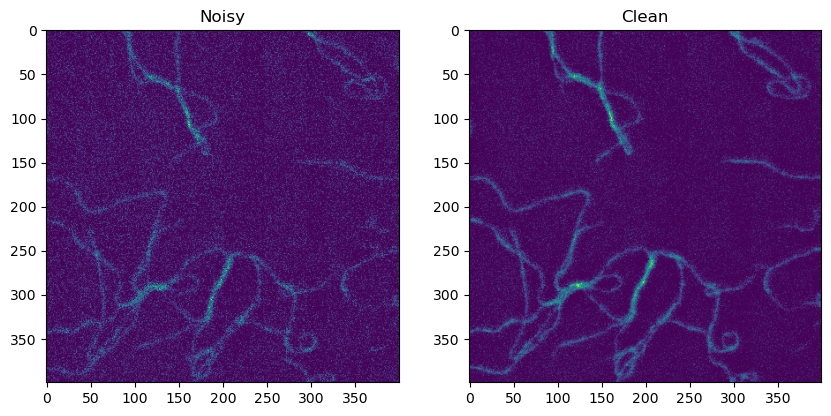

In [4]:
##### Load data ####

signal = []
observation = []
filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

for f in files_signal:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files_signal.remove(f)

for f in files_obs:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files_obs.remove(f)

assert len(files_obs) == len(files_signal)
print(f"\nFound {len(files_signal)} files.\n")

for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]
    
    # n2v or avg signal selection
    if clean == "avg":
        im_signal = imread(data_path_signal / file_signal)[0]
    elif clean == "n2v":
        im_signal = imread(data_path_signal / file_signal)[1]
    
    # noise level selection
    if noise_level == "all":
        im_obs  = imread(data_path_obs / file_obs)[:5]
    elif isinstance(noise_level,int) or isinstance(noise_level,list):
        im_obs = imread(data_path_obs / file_obs)[noise_level]

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0

    observation.append(im_obs)
    signal.append(im_signal)

    print(f"Signal {file_signal}:\tObservation {file_obs}:\t Shape: {im_obs.shape}")

signal = np.stack(signal)
observation = np.stack(observation)

if len(observation.shape) == 4:
    nrepeat = observation.shape[1]
    observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3]))    
    signal = np.repeat(signal,nrepeat,axis=0)


signal = (signal - np.mean(signal))/np.std(signal)
observation = (observation - np.mean(observation))/np.std(observation)

print(f"\n\nConcatenated arrays:\tSignal: {signal.shape}\tObservation: {observation.shape}")

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(observation[0][400:800,400:800])
plt.title("Noisy")

plt.subplot(1,2,2)
plt.imshow(signal[0][400:800,400:800])
plt.title("Clean")

In [5]:
# Split into train and val, define gt data if supervised

train_data = observation[:int(0.85*observation.shape[0])]
val_data= observation[int(0.85*observation.shape[0]):]
print("Shape of training images:", train_data.shape, "Shape of validation images:", val_data.shape)
if augment:
    train_data = utils.augment_data(train_data) ### Data augmentation disabled for fast training, but can be enabled
### Optional part with GT data if supervised###
if supervised:
    train_data_gt = signal[:int(0.85*observation.shape[0])]
    val_data_gt = signal[int(0.85*observation.shape[0]):]
    print("Shape of GT training images:", train_data.shape, "Shape of validation images:", val_data.shape)
    if augment:
        train_data_gt = utils.augment_data(train_data_gt) ### Data augmentation disabled for fast training, but can be enabled

Shape of training images: (21, 1416, 1392) Shape of validation images: (4, 1416, 1392)


In [6]:
# Patches extraction

img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(patch_size**2)*1)

if not supervised:
    train_images = utils.extract_patches(train_data, patch_size, num_patches)
    val_images = utils.extract_patches(val_data, patch_size, num_patches)
else:
    train_images,train_images_gt = utils.extract_patches_supervised(train_data,train_data_gt, patch_size, num_patches)
    val_images,val_images_gt  = utils.extract_patches_supervised(val_data,val_data_gt, patch_size, num_patches)

 # We limit validation patches to 1000 to speed up training but it is not necessary
val_images = val_images[:1000]
test_images = val_images[:100]
if supervised:
    val_images_gt = val_images_gt [:1000] 
    test_images_gt = val_images_gt[:100]
    
img_shape = (train_images.shape[1], train_images.shape[2])
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

100%|██████████| 4/4 [00:00<00:00, 138.89it/s]

Shape of training images: (10101, 64, 64) Shape of validation images: (1000, 64, 64)


In [7]:
# if supervised: Display of paired dataset to check that it is matching 

if supervised:
    import random
    idx = random.randrange(train_images.shape[0])

    plt.figure(figsize=(5,10))
    plt.subplot(1,2,1)
    plt.imshow(train_images[idx])

    plt.subplot(1,2,2)
    plt.imshow(train_images_gt[idx])

    idx = random.randrange(val_images.shape[0])
    plt.figure(figsize=(5,10))
    plt.subplot(1,2,1)
    plt.imshow(val_images[idx])

    plt.subplot(1,2,2)
    plt.imshow(val_images_gt[idx])

In [8]:
# Choose make_data_manager for supervised training or make_data_manager 2 for supervised

if not supervised:
    train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,val_images,
                                                                                            test_images,batch_size,
                                                                                            test_batch_size)

else:
    train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager_supervised(train_images,train_images_gt,val_images,
                                                                                            val_images_gt, test_images,test_images_gt,
                                                                                            batch_size,test_batch_size)

# Here we ensure that steps_per_epoch not bigger than len(train_loader)
# It never goes into validation otherwise, and so it never saves the model.
steps_per_epoch=min(len(train_loader)-1,steps_per_epoch)
print(steps_per_epoch)

157


In [9]:
# if supervised: Display of paired dataset to check that it is still matching in the loader  

if supervised:
    batch_idx, (x, y) = next(enumerate(train_loader))

    x2 = x.cpu().numpy()
    x2 = x2[0]

    y2 = y.cpu().numpy()
    y2 = y2[0]

    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(x2)
    plt.subplot(1,2,2)
    plt.imshow(y2)

    batch_idx, (x, y) = next(enumerate(val_loader))

    x2 = x.cpu().numpy()
    x2 = x2[0]

    y2 = y.cpu().numpy()
    y2 = y2[0]

    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(x2)
    plt.subplot(1,2,2)
    plt.imshow(y2)

In [10]:
# Train network

noise_model_params= np.load(str(noiseModelsDir / GMMname))
noiseModel = GaussianMixtureNoiseModel(params = noise_model_params, device = device)

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape).cuda()

model.train() # Model set in training mode

training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=save_model_basedir,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=modelName,val_loss_patience=30,beta=beta)

Epoch[1/500] Training Loss: 1.313 Reconstruction Loss: 1.235 KL Loss: 0.078
saving ./Trained_model/model/Vim_fixed_mltplSNR_30nm_Noise0_SigAVG_Clip-3_4Lat_4Blocks_NoAugment_last_vae.net
saving ./Trained_model/model/Vim_fixed_mltplSNR_30nm_Noise0_SigAVG_Clip-3_4Lat_4Blocks_NoAugment_best_vae.net
Patience: 0 Validation Loss: 1.2101205587387085 Min validation loss: 1.2101205587387085
Time for epoch: 109seconds
Est remaining time: 15:06:31 or 54391 seconds
----------------------------------------
Epoch[2/500] Training Loss: 1.236 Reconstruction Loss: 1.209 KL Loss: 0.027
saving ./Trained_model/model/Vim_fixed_mltplSNR_30nm_Noise0_SigAVG_Clip-3_4Lat_4Blocks_NoAugment_last_vae.net
saving ./Trained_model/model/Vim_fixed_mltplSNR_30nm_Noise0_SigAVG_Clip-3_4Lat_4Blocks_NoAugment_best_vae.net
Patience: 0 Validation Loss: 1.2060374021530151 Min validation loss: 1.2060374021530151
Time for epoch: 134seconds
Est remaining time: 18:32:12 or 66732 seconds
----------------------------------------
Epoc

# Plotting losses

In [ ]:
directory_path = "./Trained_model/" 
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

In [ ]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()